In [1]:
import csv
import pandas as pd
import seaborn as sns


# Caminho para o arquivo CSV
file_path = "user_courses_review_09_2023.csv"

# Lista para armazenar as linhas de dados
data_list = []

# Numero de colunas esperado por cada linha
EXPECTED_COLUMNS = 4  # Troque esse numero conforme necessário

# Abrir o arquivo CSV e ler linha por linha
with open(file_path, "r", encoding="utf-8", newline="") as file:
    reader = csv.reader(file)

    # Opcional: Ler o cabeçalho se existir
    header = next(reader)

    # Ler cada linha
    for row in reader:
        # Verificar se a linha tem o número esperado de colunas
        if len(row) == EXPECTED_COLUMNS:
            data_list.append(row)
        else:
            print(f"Linha ignorada: {reader.line_num}: {row}")

# Converter a lista de dados em um DataFrame do Pandas
df = pd.DataFrame(data_list, columns=header)

# Mostrar as primeiras linhas do DataFrame
print(df.head())

Linha ignorada: 1148: ['Data Analysis with Excel Pivot Tables', 'Creating an output structure of the FMCG model', '5', 'I remember Ross saying Pivot"', ' "Pivot" in F.R.I.E.N.D.S  ^__^"']
Linha ignorada: 1315: ['Data Analysis with Excel Pivot Tables', 'This is how the report can be used in practice by high-level executives', '4', 'Well, it\'s a great course and I learned something new. But I\'ll prefer if the practical aspect and dataset used would be one that everyone can relate to - whether an economist or not or an accountant or not. I didn\'t relate well with the practical aspect because I didn\'t understand those net sales and so on. That wasn\'t my scope of study in school so I didn\'t really get along well (or maybe the course can be renamed to Data Analysis with Pivot Tables For Financial Analysts"', ' lol). ']
Linha ignorada: 1316: ['But all the same', ' thanks so much to the instructor. You did a great job. God bless."']
Linha ignorada: 1465: ['Data Cleaning and Preprocessing

In [2]:
# Checando os data types das colunas
data_types = df.dtypes

print(data_types)

course_name       object
lecture_name      object
review_rating     object
review_comment    object
dtype: object


In [3]:
# Converter 'review_rating' para numérico
if df["review_rating"].dtype == "object":
    # Força a a conversão para numérico, tratando erros como NaN
    df["review_rating"] = pd.to_numeric(df["review_rating"], errors="coerce")

In [4]:
# Verificar se a conversão foi bem-sucedida e valores ausentes
new_data_types = df.dtypes
missing_values = df.isnull().sum()

print(new_data_types)
print(missing_values)

course_name        object
lecture_name       object
review_rating     float64
review_comment     object
dtype: object
course_name       0
lecture_name      0
review_rating     2
review_comment    0
dtype: int64


In [5]:
import matplotlib.pyplot as plt

# Summary estatistica para review_rating
review_rating_summary = df["review_rating"].describe()
print(review_rating_summary)

count    10824.000000
mean         4.840632
std          0.525791
min          1.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_rating, dtype: float64


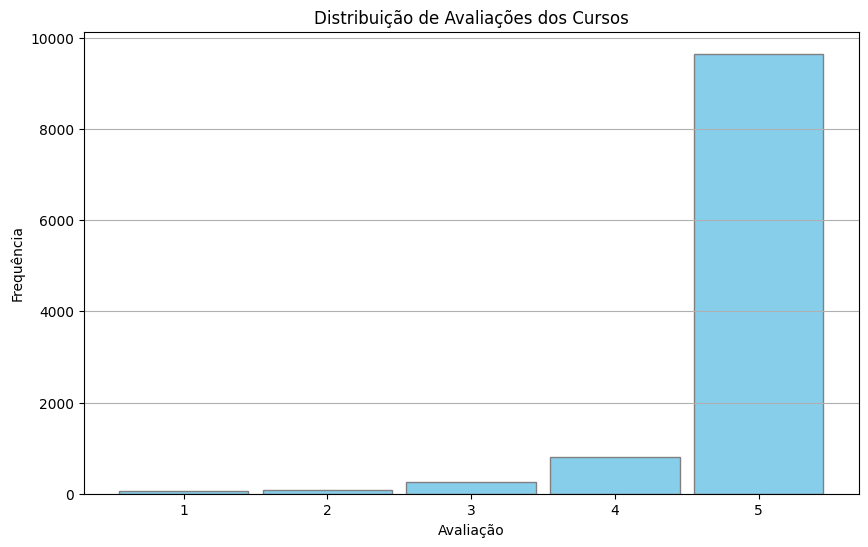

In [6]:
# Grafico de distribuição de review_rating
plt.figure(figsize=(10, 6))
plt.hist(
    df["review_rating"].dropna(),
    bins=range(1, 7),
    align="left",
    rwidth=0.9,
    color="skyblue",
    edgecolor="gray",
)
plt.title("Distribuição de Avaliações dos Cursos")
plt.xlabel("Avaliação")
plt.ylabel("Frequência")
plt.xticks(range(1, 6))
plt.grid(axis="y")
plt.show()

In [7]:
# Remover linhas com dados ausentes
df_cleaned = df.dropna().copy()

In [8]:
# Checkando o novo shape do DataFrame
print(
    f"Shape do DataFrame após remoção de linhas com dados ausentes: {df_cleaned.shape}"
)

Shape do DataFrame após remoção de linhas com dados ausentes: (10824, 4)


In [9]:
# Para analise de correlação, primeiro precisamos adicionar uma nova coluna com o tamanho dos comentarios
df_cleaned["comment_length"] = df_cleaned["review_comment"].apply(len)

In [10]:
# Calcular a correlação entre review_rating e comment_length
correlation = df_cleaned[["review_rating", "comment_length"]].corr()

print(correlation)

                review_rating  comment_length
review_rating        1.000000       -0.281202
comment_length      -0.281202        1.000000


In [11]:
import re

# Define regex patterns para procurar palavras-chave
patterns = {
    "positive": re.compile(
        r"\b(good|great|excellent|amazing|love|enjoy|awesome|best|fantastic)\b",
        re.IGNORECASE,
    ),
    "negative": re.compile(
        r"\b(bad|terrible|awful|hate|dislike|poor|worst|disappoint)\b", re.IGNORECASE
    ),
    "question": re.compile(r"\?"),
    "exclamation": re.compile(r"\!"),
    "capitalized": re.compile(
        r"\b[A-Z]{2,}\b"
    ),  # palavras com 2 ou mais letras maiúsculas
}

# Inicializa um dicionário para armazenar as contagens para cada padrão
pattern_counts = {key: 0 for key in patterns}

# Scan cada comentário e contar as ocorrências de cada padrão
for comment in df_cleaned["review_comment"]:
    for key, pattern in patterns.items():
        if re.search(pattern, comment):
            pattern_counts[key] += 1

pattern_counts

{'positive': 6162,
 'negative': 23,
 'question': 31,
 'exclamation': 1180,
 'capitalized': 535}

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import string


# Função para pré-processar os comentários
def preprocess_text(text):
    # Remove pontuação e converte para minúsculas
    text = text.translate(str.maketrans("", "", string.punctuation)).lower()
    return text


# Aplicar a função de pré-processamento
df_cleaned["review_comment"] = df_cleaned["review_comment"].apply(preprocess_text)

# Dividir os dados em conjunto de treino e teste
X = df_cleaned.loc[:, "review_comment"]
Y = df_cleaned.loc[:, "review_comment"]

# Dividir os dados entre treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [13]:
# Inicializar a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english")

# Inicializar o modelo Naive Bayes Multinomial
model = MultinomialNB()

# Criar uma pipeline que combina o vetorizar e o modelo
pipeline = make_pipeline(vectorizer, model)

# Treinar o modelo
pipeline.fit(X_train, Y_train)

# Fazer previsões no conjunto de teste
Y_pred = pipeline.predict(X_test)

# Calcular e exibir o relatório de classificação
report = classification_report(Y_test, Y_pred)

# Exibir a matriz de confusão
conf_matrix = confusion_matrix(Y_test, Y_pred)
report, conf_matrix

c:\Users\Leo\Documents\Sites\Data Analysis Projects\Users Reviews - NPL - Naive Bayes\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  self.y_type_ = type_of_target(y, input_name="y")
c:\Users\Leo\Documents\Sites\Data Analysis Projects\Users Reviews - NPL - Naive Bayes\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\Leo\Documents\Sites\Data Analysis Projects\Users Reviews - NPL - Naive Bayes\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:359: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  y_is_multilabel = type_of_target(y).startswith("multilabel")
c:\Users\Leo\Documents\Sites\Data Analysis Projects\Users Reviews - NPL - Naive Bayes\.venv\Lib\site-packages\sklearn\preprocessing\_label

('                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [14]:
from sklearn.utils import resample

# Separar as classes minoritárias e majoritárias
df_majority = df_cleaned[df_cleaned["review_rating"] == 5]
df_minority = df_cleaned[df_cleaned["review_rating"] < 5]

# Upsample a classe minoritária
df_minority_upsampled = resample(
    df_minority,
    replace=True,  # Amostragem com reposição
    n_samples=len(
        df_majority
    ),  # Para igualar o número de amostras da classe majoritária
    random_state=42,
)  # Para reprodutibilidade

# Combinar a classe majoritária com a classe minoritária upsampled
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Verificar o novo balanceamento das classes
print(df_balanced["review_rating"].value_counts())

review_rating
5.0    9648
4.0    6533
3.0    2131
2.0     592
1.0     392
Name: count, dtype: int64


In [15]:
# Separar os dados balanceados em X e Y
X_balanced = df_balanced["review_comment"]
Y_balanced = df_balanced["review_rating"]

# Dividir os dados balanceados entre treino e teste
X_train_balanced, X_test_balanced, Y_train_balanced, Y_test_balanced = train_test_split(
    X_balanced, Y_balanced, test_size=0.2, random_state=42
)

# Treinar o modelo novamente com os dados balanceados
pipeline_upsampled = make_pipeline(vectorizer, model)
pipeline_upsampled.fit(X_train_balanced, Y_train_balanced)

# Fazer previsões no conjunto de teste balanceado
Y_pred_balanced = pipeline_upsampled.predict(X_test_balanced)

# Calcular e exibir o relatório de classificação para os dados balanceados
report_balanced = classification_report(Y_test_balanced, Y_pred_balanced)

# Calcular a matriz de confusão para os dados balanceados
conf_matrix_balanced = confusion_matrix(Y_test_balanced, Y_pred_balanced)

report_balanced, conf_matrix_balanced

('              precision    recall  f1-score   support\n\n         1.0       1.00      0.19      0.31        75\n         2.0       1.00      0.28      0.43       123\n         3.0       0.90      0.55      0.68       396\n         4.0       0.70      0.62      0.66      1323\n         5.0       0.73      0.91      0.81      1943\n\n    accuracy                           0.74      3860\n   macro avg       0.87      0.51      0.58      3860\nweighted avg       0.75      0.74      0.72      3860\n',
 array([[  14,    0,    6,   24,   31],
        [   0,   34,    9,   53,   27],
        [   0,    0,  218,  101,   77],
        [   0,    0,    1,  818,  504],
        [   0,    0,    8,  169, 1766]]))

### Classification Task

In [16]:
# Define a função para converter o 'rating' em 'good' ou 'bad'
def binary_rating(rating):
    if rating >= 4:
        return "good"
    else:
        return "bad"


# Aplica a função de conversão ao DataFrame na coluna 'review_rating'
binary_data = df_cleaned.copy()
binary_data["review_rating"] = binary_data["review_rating"].apply(binary_rating)

# Separar os dados binários em X e Y
X_binary = binary_data["review_comment"]
Y_binary = binary_data["review_rating"]

# Dividir os dados binários entre treino e teste
X_train_binary, X_test_binary, Y_train_binary, Y_test_binary = train_test_split(
    X_binary, Y_binary, test_size=0.2, random_state=42
)

# Treinar o modelo novamente com os dados binários
pipeline_binary = make_pipeline(vectorizer, model)
pipeline_binary.fit(X_train_binary, Y_train_binary)

# Fazer previsões no conjunto de teste binário
Y_pred_binary = pipeline_binary.predict(X_test_binary)

# Calcular e exibir o relatório de classificação para os dados binários
report_binary = classification_report(Y_test_binary, Y_pred_binary, output_dict=True)

# Calcular a matriz de confusão para os dados binários
conf_matrix_binary = confusion_matrix(Y_test_binary, Y_pred_binary)

# Cnoverte o reporte de classificação em um DataFrame
report_binary_df = pd.DataFrame(report_binary).transpose()

report_binary_df

c:\Users\Leo\Documents\Sites\Data Analysis Projects\Users Reviews - NPL - Naive Bayes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Leo\Documents\Sites\Data Analysis Projects\Users Reviews - NPL - Naive Bayes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Leo\Documents\Sites\Data Analysis Projects\Users Reviews - NPL - Naive Bayes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0

,precision,recall,f1-score,support
bad,0.000000,0.000000,0.000000,83.000000
good,0.961663,1.000000,0.980457,2082.000000
accuracy,0.961663,0.961663,0.961663,0.961663
macro avg,0.480831,0.500000,0.490228,2165.000000
weighted avg,0.924795,0.961663,0.942869,2165.000000


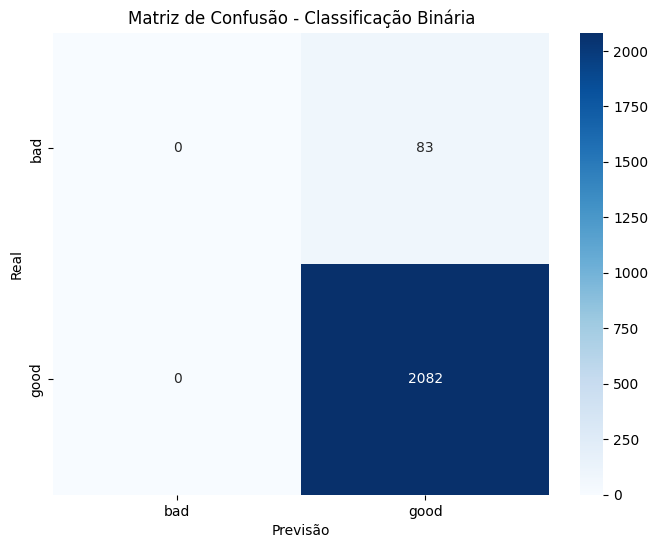

In [17]:
# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_binary,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["bad", "good"],
    yticklabels=["bad", "good"],
)
plt.title("Matriz de Confusão - Classificação Binária")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

In [18]:
# Separar os dados majoritários e minoritários
df_majority = binary_data[binary_data["review_rating"] == "good"]
df_minority = binary_data[binary_data["review_rating"] == "bad"]

# Oversample a classe minoritária
df_minority_upsampled_binary = resample(
    df_minority,
    replace=True,  # Amostragem com reposição
    n_samples=len(
        df_majority
    ),  # Para igualar o número de amostras da classe majoritária
    random_state=42,
)  # Para reprodutibilidade

# Combinar a classe majoritária com a classe minoritária upsampled
df_balanced_binary = pd.concat([df_majority, df_minority_upsampled_binary])

# Verificar o novo balanceamento das classes
print(df_balanced_binary["review_rating"].value_counts())

review_rating
good    10448
bad     10448
Name: count, dtype: int64


In [19]:
# Separar os dados upsampled binary data em features(X) e labels(Y)
X_upsampled_binary = df_balanced_binary["review_comment"]
Y_upsampled_binary = df_balanced_binary["review_rating"]

# Dividir os dados balanceados entre treino e teste
(
    X_train_upsampled_binary,
    X_test_upsampled_binary,
    Y_train_upsampled_binary,
    Y_test_upsampled_binary,
) = train_test_split(
    X_upsampled_binary, Y_upsampled_binary, test_size=0.2, random_state=42
)

# Treinar o modelo novamente com os dados balanceados binários
pipeline_upsampled_binary = make_pipeline(vectorizer, model)
pipeline_upsampled_binary.fit(X_train_upsampled_binary, Y_train_upsampled_binary)

# Fazer previsões no conjunto de teste balanceado binário
Y_pred_upsampled_binary = pipeline_upsampled_binary.predict(X_test_upsampled_binary)

# Calcular e exibir o relatório de classificação para os dados balanceados binários
report_upsampled_binary = classification_report(
    Y_test_upsampled_binary, Y_pred_upsampled_binary, output_dict=True
)

# Calcular a matriz de confusão para os dados balanceados binários
conf_matrix_upsampled_binary = confusion_matrix(
    Y_test_upsampled_binary, Y_pred_upsampled_binary
)

# Converte o reporte de classificação em um DataFrame
report_upsampled_binary_df = pd.DataFrame(report_upsampled_binary).transpose()

report_upsampled_binary_df

,precision,recall,f1-score,support
bad,0.875114,0.940255,0.906516,2042.000000
good,0.938570,0.871843,0.903977,2138.000000
accuracy,0.905263,0.905263,0.905263,0.905263
macro avg,0.906842,0.906049,0.905246,4180.000000
weighted avg,0.907571,0.905263,0.905217,4180.000000


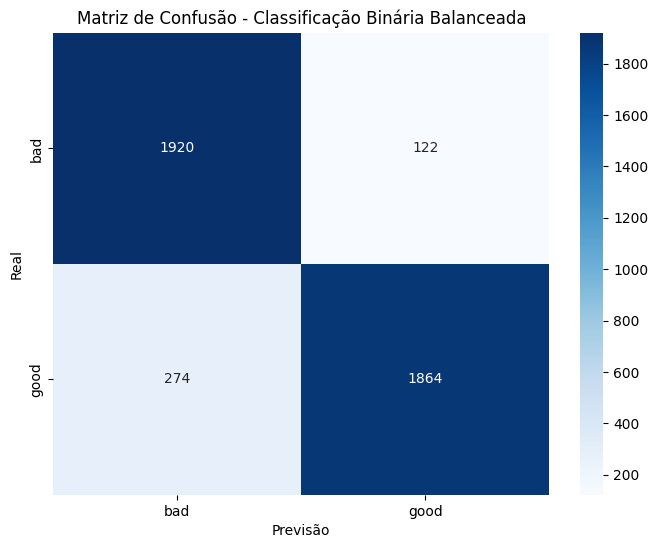

In [20]:
# Fazer o plot da matriz de confusão como heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_upsampled_binary,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["bad", "good"],
    yticklabels=["bad", "good"],
)
plt.title("Matriz de Confusão - Classificação Binária Balanceada")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

### Teste Set

In [21]:
# Carregar o arquivo de teste
test_file = pd.read_csv(
    "user_courses_review_test.csv",
    encoding="utf-8",
)

In [22]:
# Remover linhas com dados ausentes em 'review_comment' ou 'review_rating'
test_set_clean = test_file.dropna(subset=["review_comment", "review_rating"]).copy()

In [23]:
# Converter 'review_rating' para numérico
test_set_clean["review_rating"] = pd.to_numeric(
    test_set_clean["review_rating"], errors="coerce"
)

In [24]:
# Checar se há NaN após a conversão e remover essas linhas
test_set_clean = test_set_clean.dropna(subset=["review_rating"])

In [25]:
# Função para categorizar as reviews
def binary_rating(rating):
    return "good" if rating >= 4.0 else "bad"

In [26]:
# Limpar review_comment
test_set_clean["review_comment"] = test_set_clean["review_comment"].apply(
    preprocess_text
)

In [27]:
# Aplicar 'binary_rating' para converter 'review_rating' em 'good' ou 'bad'
test_set_clean["review_rating"] = test_set_clean["review_rating"].apply(binary_rating)

In [28]:
# Ter certeza que o processamento foi feito corretamente
test_set_clean.head()

,course_name,lecture_name,review_rating,review_comment
0,Advanced Microsoft Excel,F1 to F12 - Using Excel's Function Keys,good,perfect
1,Agile and Scrum Project Management,Agile vs Waterfall - Conclusions,bad,the scrum chapter are full of errors
2,AI Applications for Business Success,Correlation vs. Causation,bad,bad quality of audio and narrative
3,AI Applications for Business Success,Correlation vs. Causation,bad,i need documentation about lecture
4,Building a 3-Statement Model in Excel,Calculating Cash Flows and Completing the Mode...,good,great course ned has a talent for explaining t...


In [29]:
# Preparar as features e labels do modelo limpo, para teste
X_test_clean = test_set_clean["review_comment"]
Y_test_clean = test_set_clean["review_rating"]

In [30]:
# Fazer previsões no conjunto de teste limpo
Y_test_pred_clean = pipeline_upsampled_binary.predict(X_test_clean)

In [31]:
# Calcular a classificação do relatório para o conjunto de teste limpo
report_test_clean = classification_report(
    Y_test_clean, Y_test_pred_clean, output_dict=True
)

In [32]:
# Calcular a matriz de confusão para o conjunto de teste limpo
conf_matrix_test_clean = confusion_matrix(Y_test_clean, Y_test_pred_clean)

In [33]:
# Converter a classificação do relatório em um DataFrame
report_test_clean_df = pd.DataFrame(report_test_clean).transpose()

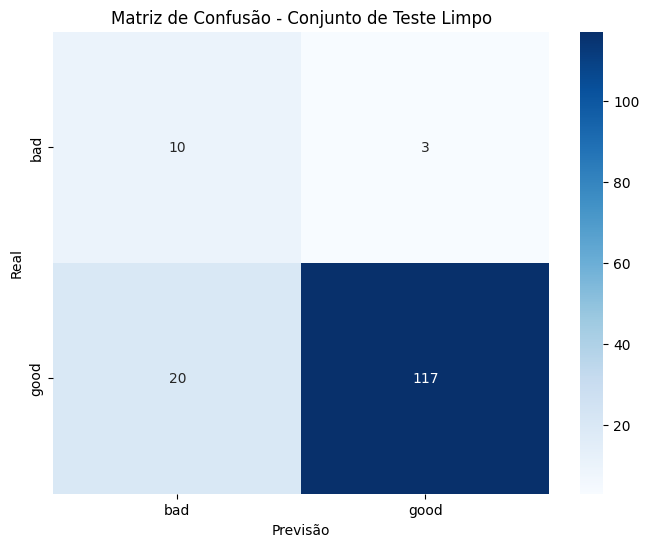

In [34]:
# Plotar a matriz de confusão do conjunto de teste limpo em heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_test_clean,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["bad", "good"],
    yticklabels=["bad", "good"],
)
plt.title("Matriz de Confusão - Conjunto de Teste Limpo")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

In [35]:
print(report_test_clean_df)

              precision    recall  f1-score     support
bad            0.333333  0.769231  0.465116   13.000000
good           0.975000  0.854015  0.910506  137.000000
accuracy       0.846667  0.846667  0.846667    0.846667
macro avg      0.654167  0.811623  0.687811  150.000000
weighted avg   0.919389  0.846667  0.871905  150.000000
